## Simple CNN

### 設置dataset and dataloader

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import tqdm
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# 超參數設置
num_epochs = 10
batch_size = 16
learning_rate = 0.001

# 設置訓練數據讀取器
train_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_dataset = ImageFolder("/home/kevinluo/breast_density_classification/datasets/train", transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 設置驗證數據讀取器
valid_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
valid_dataset = ImageFolder("/home/kevinluo/breast_density_classification/datasets/valid", transform=valid_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 設置測試數據讀取器
test_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_dataset = ImageFolder("/home/kevinluo/breast_density_classification/datasets/test", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 設置模型
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 160 * 160, 256)
        self.fc2 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 160 * 160)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

cuda:0


### 設置net

In [16]:
net = CNNClassifier()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [17]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    # 訓練模式
    net.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
    train_loss /= len(train_dataset)
    train_acc = train_acc.double() / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 驗證模式
    net.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            valid_acc += torch.sum(preds == labels.data)
        valid_loss /= len(valid_dataset)
        valid_acc = valid_acc.double() / len(valid_dataset)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    # 打印訓練過程
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(
        epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))
    #測試模型
    net.eval()
    test_acc = 0.0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)
            pred_labels.extend(preds.tolist())
            true_labels.extend(labels.tolist())
            test_acc = test_acc.double() / len(test_dataset)
    print('Test Acc: {:.4f}'.format(test_acc))

Epoch [1/10], Train Loss: 3.4464, Train Acc: 0.4443, Valid Loss: 1.1791, Valid Acc: 0.5151
Test Acc: 0.0000
Epoch [2/10], Train Loss: 1.1659, Train Acc: 0.5014, Valid Loss: 1.1802, Valid Acc: 0.4816
Test Acc: 0.0034
Epoch [3/10], Train Loss: 1.0770, Train Acc: 0.5407, Valid Loss: 1.2677, Valid Acc: 0.5184
Test Acc: 0.0034
Epoch [4/10], Train Loss: 0.9742, Train Acc: 0.5956, Valid Loss: 1.2701, Valid Acc: 0.4883
Test Acc: 0.0000
Epoch [5/10], Train Loss: 0.8618, Train Acc: 0.6423, Valid Loss: 1.2992, Valid Acc: 0.4883
Test Acc: 0.0017
Epoch [6/10], Train Loss: 0.6845, Train Acc: 0.7368, Valid Loss: 1.3771, Valid Acc: 0.4548
Test Acc: 0.0017
Epoch [7/10], Train Loss: 0.5071, Train Acc: 0.8150, Valid Loss: 1.4780, Valid Acc: 0.4816
Test Acc: 0.0017
Epoch [8/10], Train Loss: 0.3611, Train Acc: 0.8707, Valid Loss: 1.7922, Valid Acc: 0.4415
Test Acc: 0.0000
Epoch [9/10], Train Loss: 0.2774, Train Acc: 0.9142, Valid Loss: 1.8582, Valid Acc: 0.4482
Test Acc: 0.0034
Epoch [10/10], Train Loss: 0

### 繪製loss和accuracy曲線

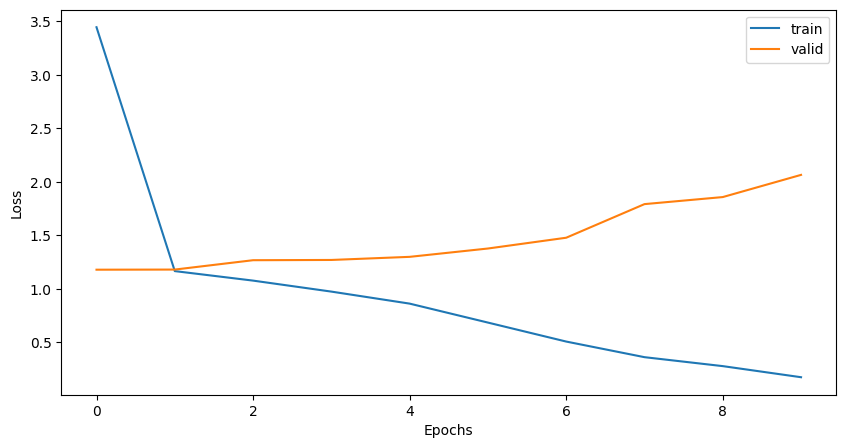

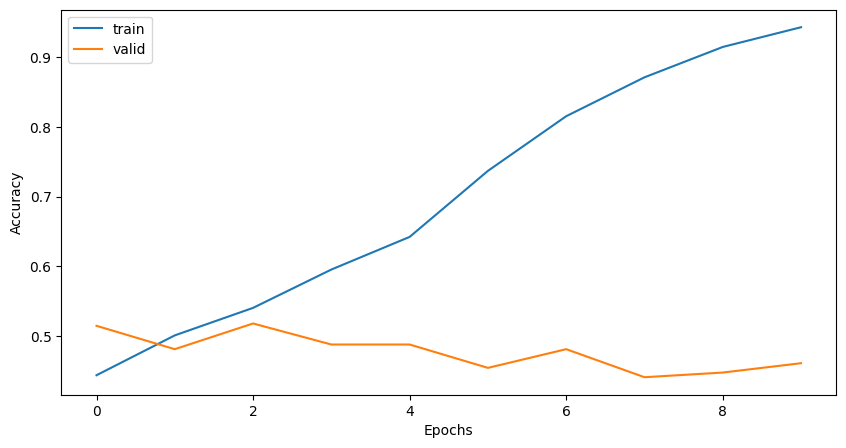

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 繪製confusion matrix

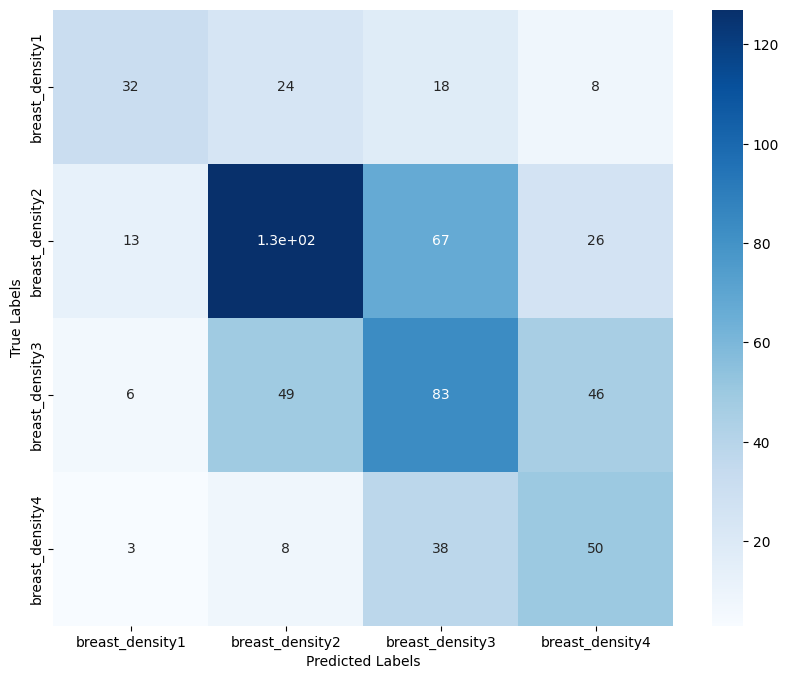

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 一樣的simple CNN 但改成GPU完全使用, 和多加進度條。

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import tqdm
######

In [40]:
#定義loss和optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    # 訓練模式
    model.train()
    for images, labels in tqdm.tqdm(train_loader, desc="Train Epoch {}".format(epoch)):
        # 將數據移至GPU上
        images = images.to(device)
        labels = labels.to(device)

        # 清零梯度
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向傳播和優化
        loss.backward()
        optimizer.step()

        # 計算訓練損失和訓練準確率
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    # 計算訓練平均損失和訓練平均準確率
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc.double() / len(train_loader.dataset)

    # 驗證模式
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm.tqdm(valid_loader, desc="Valid Epoch {}".format(epoch)):
            # 將數據移至GPU上
            images = images.to(device)
            labels = labels.to(device)

            # 前向傳播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 計算驗證損失和驗證準確率
            valid_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            valid_acc += torch.sum(preds == labels.data)

    # 計算驗證平均損失和驗證平均準確率
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_acc = valid_acc.double() / len(valid_loader.dataset)

    # 輸出訓練和驗證結果
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
        .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))


Valid Epoch 0: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch [1/100], Train Loss: 1.9604, Train Acc: 0.4701, Valid Loss: 1.1227, Valid Acc: 0.5084


Valid Epoch 1: 100%|██████████| 19/19 [00:02<00:00,  8.89it/s]


Epoch [2/100], Train Loss: 1.0966, Train Acc: 0.5193, Valid Loss: 1.1367, Valid Acc: 0.5217


Valid Epoch 2: 100%|██████████| 19/19 [00:01<00:00,  9.68it/s]


Epoch [3/100], Train Loss: 1.0493, Train Acc: 0.5478, Valid Loss: 1.1655, Valid Acc: 0.5217


Valid Epoch 3: 100%|██████████| 19/19 [00:01<00:00, 10.28it/s]


Epoch [4/100], Train Loss: 1.0063, Train Acc: 0.5695, Valid Loss: 1.1520, Valid Acc: 0.5084


Valid Epoch 4: 100%|██████████| 19/19 [00:01<00:00,  9.53it/s]


Epoch [5/100], Train Loss: 0.9819, Train Acc: 0.5880, Valid Loss: 1.1810, Valid Acc: 0.5351


Valid Epoch 5: 100%|██████████| 19/19 [00:01<00:00,  9.66it/s]


Epoch [6/100], Train Loss: 0.8971, Train Acc: 0.6285, Valid Loss: 1.2534, Valid Acc: 0.4983


Valid Epoch 6: 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


Epoch [7/100], Train Loss: 0.7579, Train Acc: 0.6977, Valid Loss: 1.3315, Valid Acc: 0.4983


Valid Epoch 7: 100%|██████████| 19/19 [00:02<00:00,  8.60it/s]


Epoch [8/100], Train Loss: 0.6236, Train Acc: 0.7672, Valid Loss: 1.3828, Valid Acc: 0.4849


Valid Epoch 8: 100%|██████████| 19/19 [00:01<00:00,  9.69it/s]


Epoch [9/100], Train Loss: 0.4294, Train Acc: 0.8427, Valid Loss: 1.7505, Valid Acc: 0.4749


Valid Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  9.04it/s]


Epoch [10/100], Train Loss: 0.3017, Train Acc: 0.8992, Valid Loss: 1.7369, Valid Acc: 0.4783


Valid Epoch 10: 100%|██████████| 19/19 [00:02<00:00,  8.79it/s]


Epoch [11/100], Train Loss: 0.2144, Train Acc: 0.9340, Valid Loss: 1.9664, Valid Acc: 0.4916


Valid Epoch 11: 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


Epoch [12/100], Train Loss: 0.1351, Train Acc: 0.9606, Valid Loss: 2.3481, Valid Acc: 0.4682


Valid Epoch 12: 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]


Epoch [13/100], Train Loss: 0.1015, Train Acc: 0.9661, Valid Loss: 2.5490, Valid Acc: 0.4783


Valid Epoch 13: 100%|██████████| 19/19 [00:02<00:00,  8.72it/s]


Epoch [14/100], Train Loss: 0.0576, Train Acc: 0.9818, Valid Loss: 3.0092, Valid Acc: 0.4783


Valid Epoch 14: 100%|██████████| 19/19 [00:01<00:00,  9.99it/s]


Epoch [15/100], Train Loss: 0.0415, Train Acc: 0.9875, Valid Loss: 3.0469, Valid Acc: 0.4615


Valid Epoch 15: 100%|██████████| 19/19 [00:01<00:00,  9.90it/s]


Epoch [16/100], Train Loss: 0.0544, Train Acc: 0.9848, Valid Loss: 3.5241, Valid Acc: 0.4080


Valid Epoch 16: 100%|██████████| 19/19 [00:01<00:00, 10.13it/s]


Epoch [17/100], Train Loss: 0.0700, Train Acc: 0.9794, Valid Loss: 3.3851, Valid Acc: 0.4181


Valid Epoch 17: 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


Epoch [18/100], Train Loss: 0.0396, Train Acc: 0.9883, Valid Loss: 3.8512, Valid Acc: 0.4448


Valid Epoch 18: 100%|██████████| 19/19 [00:01<00:00, 10.28it/s]


Epoch [19/100], Train Loss: 0.0308, Train Acc: 0.9902, Valid Loss: 3.8259, Valid Acc: 0.4682


Valid Epoch 19: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


Epoch [20/100], Train Loss: 0.0110, Train Acc: 0.9965, Valid Loss: 3.9776, Valid Acc: 0.4482


Valid Epoch 20: 100%|██████████| 19/19 [00:02<00:00,  9.26it/s]


Epoch [21/100], Train Loss: 0.0154, Train Acc: 0.9954, Valid Loss: 4.2974, Valid Acc: 0.4348


Valid Epoch 21: 100%|██████████| 19/19 [00:02<00:00,  9.02it/s]


Epoch [22/100], Train Loss: 0.0148, Train Acc: 0.9935, Valid Loss: 4.3378, Valid Acc: 0.4214


Valid Epoch 22: 100%|██████████| 19/19 [00:01<00:00, 10.62it/s]


Epoch [23/100], Train Loss: 0.0096, Train Acc: 0.9970, Valid Loss: 4.3724, Valid Acc: 0.4214


Valid Epoch 23: 100%|██████████| 19/19 [00:02<00:00,  9.12it/s]


Epoch [24/100], Train Loss: 0.0315, Train Acc: 0.9910, Valid Loss: 4.1341, Valid Acc: 0.4181


Valid Epoch 24: 100%|██████████| 19/19 [00:01<00:00,  9.58it/s]


Epoch [25/100], Train Loss: 0.0118, Train Acc: 0.9962, Valid Loss: 5.0270, Valid Acc: 0.4114


Valid Epoch 25: 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


Epoch [26/100], Train Loss: 0.0045, Train Acc: 0.9989, Valid Loss: 4.8071, Valid Acc: 0.4181


Valid Epoch 26: 100%|██████████| 19/19 [00:02<00:00,  9.43it/s]


Epoch [27/100], Train Loss: 0.0067, Train Acc: 0.9986, Valid Loss: 4.7904, Valid Acc: 0.3846


Valid Epoch 27: 100%|██████████| 19/19 [00:01<00:00,  9.91it/s]


Epoch [28/100], Train Loss: 0.0135, Train Acc: 0.9965, Valid Loss: 4.4136, Valid Acc: 0.4314


Valid Epoch 28: 100%|██████████| 19/19 [00:01<00:00, 10.17it/s]


Epoch [29/100], Train Loss: 0.0026, Train Acc: 0.9995, Valid Loss: 4.7366, Valid Acc: 0.4448


Valid Epoch 29: 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


Epoch [30/100], Train Loss: 0.0360, Train Acc: 0.9913, Valid Loss: 5.1343, Valid Acc: 0.3712


Valid Epoch 30: 100%|██████████| 19/19 [00:01<00:00,  9.90it/s]


Epoch [31/100], Train Loss: 0.0224, Train Acc: 0.9932, Valid Loss: 5.2304, Valid Acc: 0.3880


Valid Epoch 31: 100%|██████████| 19/19 [00:02<00:00,  9.39it/s]


Epoch [32/100], Train Loss: 0.0402, Train Acc: 0.9902, Valid Loss: 4.2806, Valid Acc: 0.3913


Valid Epoch 32: 100%|██████████| 19/19 [00:01<00:00,  9.70it/s]


Epoch [33/100], Train Loss: 0.0222, Train Acc: 0.9946, Valid Loss: 4.9564, Valid Acc: 0.4314


Valid Epoch 33: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


Epoch [34/100], Train Loss: 0.0097, Train Acc: 0.9976, Valid Loss: 4.7559, Valid Acc: 0.4381


Valid Epoch 34: 100%|██████████| 19/19 [00:02<00:00,  8.82it/s]


Epoch [35/100], Train Loss: 0.0030, Train Acc: 0.9992, Valid Loss: 5.4582, Valid Acc: 0.4582


Valid Epoch 35: 100%|██████████| 19/19 [00:01<00:00,  9.94it/s]


Epoch [36/100], Train Loss: 0.0120, Train Acc: 0.9967, Valid Loss: 5.2928, Valid Acc: 0.4114


Valid Epoch 36: 100%|██████████| 19/19 [00:01<00:00, 10.21it/s]


Epoch [37/100], Train Loss: 0.0098, Train Acc: 0.9967, Valid Loss: 4.7316, Valid Acc: 0.3813


Valid Epoch 37: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch [38/100], Train Loss: 0.0308, Train Acc: 0.9908, Valid Loss: 5.7053, Valid Acc: 0.3880


Valid Epoch 38: 100%|██████████| 19/19 [00:01<00:00,  9.86it/s]


Epoch [39/100], Train Loss: 0.0287, Train Acc: 0.9932, Valid Loss: 6.6336, Valid Acc: 0.4080


Valid Epoch 39: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch [40/100], Train Loss: 0.0249, Train Acc: 0.9943, Valid Loss: 5.1301, Valid Acc: 0.4348


Valid Epoch 40: 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]


Epoch [41/100], Train Loss: 0.0101, Train Acc: 0.9973, Valid Loss: 5.1626, Valid Acc: 0.4247


Valid Epoch 41: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Epoch [42/100], Train Loss: 0.0018, Train Acc: 0.9995, Valid Loss: 5.6579, Valid Acc: 0.4348


Valid Epoch 42: 100%|██████████| 19/19 [00:01<00:00,  9.53it/s]


Epoch [43/100], Train Loss: 0.0037, Train Acc: 0.9992, Valid Loss: 5.4402, Valid Acc: 0.4181


Valid Epoch 43: 100%|██████████| 19/19 [00:01<00:00,  9.94it/s]


Epoch [44/100], Train Loss: 0.0333, Train Acc: 0.9919, Valid Loss: 5.5634, Valid Acc: 0.4080


Valid Epoch 44: 100%|██████████| 19/19 [00:01<00:00,  9.73it/s]


Epoch [45/100], Train Loss: 0.0048, Train Acc: 0.9986, Valid Loss: 6.1734, Valid Acc: 0.4448


Valid Epoch 45: 100%|██████████| 19/19 [00:01<00:00, 10.00it/s]


Epoch [46/100], Train Loss: 0.0460, Train Acc: 0.9910, Valid Loss: 7.3992, Valid Acc: 0.3378


Valid Epoch 46: 100%|██████████| 19/19 [00:01<00:00, 10.18it/s]


Epoch [47/100], Train Loss: 0.0340, Train Acc: 0.9929, Valid Loss: 5.9940, Valid Acc: 0.4214


Valid Epoch 47: 100%|██████████| 19/19 [00:02<00:00,  9.20it/s]


Epoch [48/100], Train Loss: 0.0112, Train Acc: 0.9967, Valid Loss: 5.7803, Valid Acc: 0.4448


Valid Epoch 48: 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]


Epoch [49/100], Train Loss: 0.0114, Train Acc: 0.9973, Valid Loss: 6.2481, Valid Acc: 0.4314


Valid Epoch 49: 100%|██████████| 19/19 [00:01<00:00, 10.10it/s]


Epoch [50/100], Train Loss: 0.0071, Train Acc: 0.9981, Valid Loss: 5.9456, Valid Acc: 0.4047


Valid Epoch 50: 100%|██████████| 19/19 [00:01<00:00,  9.57it/s]


Epoch [51/100], Train Loss: 0.0035, Train Acc: 0.9986, Valid Loss: 6.4122, Valid Acc: 0.4448


Valid Epoch 51: 100%|██████████| 19/19 [00:01<00:00,  9.51it/s]


Epoch [52/100], Train Loss: 0.0015, Train Acc: 0.9995, Valid Loss: 6.9219, Valid Acc: 0.4682


Valid Epoch 52: 100%|██████████| 19/19 [00:02<00:00,  9.20it/s]


Epoch [53/100], Train Loss: 0.0010, Train Acc: 0.9995, Valid Loss: 7.0839, Valid Acc: 0.4582


Valid Epoch 53: 100%|██████████| 19/19 [00:01<00:00, 10.06it/s]


Epoch [54/100], Train Loss: 0.0009, Train Acc: 0.9995, Valid Loss: 6.9432, Valid Acc: 0.4582


Valid Epoch 54: 100%|██████████| 19/19 [00:02<00:00,  9.29it/s]


Epoch [55/100], Train Loss: 0.0009, Train Acc: 0.9995, Valid Loss: 7.3449, Valid Acc: 0.4515


Valid Epoch 55: 100%|██████████| 19/19 [00:01<00:00,  9.91it/s]


Epoch [56/100], Train Loss: 0.0009, Train Acc: 0.9995, Valid Loss: 7.0629, Valid Acc: 0.4582


Valid Epoch 56: 100%|██████████| 19/19 [00:01<00:00, 11.04it/s]


Epoch [57/100], Train Loss: 0.0007, Train Acc: 1.0000, Valid Loss: 7.3443, Valid Acc: 0.4649


Valid Epoch 57: 100%|██████████| 19/19 [00:01<00:00,  9.81it/s]


Epoch [58/100], Train Loss: 0.0005, Train Acc: 1.0000, Valid Loss: 7.6764, Valid Acc: 0.4783


Valid Epoch 58: 100%|██████████| 19/19 [00:01<00:00,  9.86it/s]


Epoch [59/100], Train Loss: 0.0004, Train Acc: 1.0000, Valid Loss: 7.5139, Valid Acc: 0.4548


Valid Epoch 59: 100%|██████████| 19/19 [00:01<00:00, 10.05it/s]


Epoch [60/100], Train Loss: 0.0004, Train Acc: 1.0000, Valid Loss: 7.4109, Valid Acc: 0.4515


Valid Epoch 60: 100%|██████████| 19/19 [00:01<00:00,  9.51it/s]


Epoch [61/100], Train Loss: 0.0003, Train Acc: 1.0000, Valid Loss: 7.8403, Valid Acc: 0.4615


Valid Epoch 61: 100%|██████████| 19/19 [00:01<00:00, 10.35it/s]


Epoch [62/100], Train Loss: 0.0047, Train Acc: 0.9978, Valid Loss: 6.9902, Valid Acc: 0.4080


Valid Epoch 62: 100%|██████████| 19/19 [00:01<00:00, 10.22it/s]


Epoch [63/100], Train Loss: 0.3212, Train Acc: 0.9823, Valid Loss: 6.8392, Valid Acc: 0.3880


Valid Epoch 63: 100%|██████████| 19/19 [00:01<00:00, 11.00it/s]


Epoch [64/100], Train Loss: 0.0230, Train Acc: 0.9957, Valid Loss: 7.6284, Valid Acc: 0.4013


Valid Epoch 64: 100%|██████████| 19/19 [00:01<00:00, 10.63it/s]


Epoch [65/100], Train Loss: 0.0054, Train Acc: 0.9986, Valid Loss: 7.4362, Valid Acc: 0.4080


Valid Epoch 65: 100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


Epoch [66/100], Train Loss: 0.0075, Train Acc: 0.9984, Valid Loss: 6.7296, Valid Acc: 0.3913


Valid Epoch 66: 100%|██████████| 19/19 [00:01<00:00, 10.17it/s]


Epoch [67/100], Train Loss: 0.0050, Train Acc: 0.9984, Valid Loss: 7.0920, Valid Acc: 0.3679


Valid Epoch 67: 100%|██████████| 19/19 [00:02<00:00,  9.35it/s]


Epoch [68/100], Train Loss: 0.0200, Train Acc: 0.9965, Valid Loss: 6.6757, Valid Acc: 0.4348


Valid Epoch 68: 100%|██████████| 19/19 [00:01<00:00,  9.68it/s]


Epoch [69/100], Train Loss: 0.0103, Train Acc: 0.9984, Valid Loss: 6.5074, Valid Acc: 0.3846


Valid Epoch 69: 100%|██████████| 19/19 [00:01<00:00, 10.16it/s]


Epoch [70/100], Train Loss: 0.0286, Train Acc: 0.9962, Valid Loss: 8.0682, Valid Acc: 0.3813


Valid Epoch 70: 100%|██████████| 19/19 [00:01<00:00,  9.75it/s]


Epoch [71/100], Train Loss: 0.0330, Train Acc: 0.9940, Valid Loss: 6.4898, Valid Acc: 0.3746


Valid Epoch 71: 100%|██████████| 19/19 [00:02<00:00,  9.46it/s]


Epoch [72/100], Train Loss: 0.0095, Train Acc: 0.9976, Valid Loss: 6.9049, Valid Acc: 0.4214


Valid Epoch 72: 100%|██████████| 19/19 [00:01<00:00, 10.63it/s]


Epoch [73/100], Train Loss: 0.0100, Train Acc: 0.9976, Valid Loss: 6.9002, Valid Acc: 0.3846


Valid Epoch 73: 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


Epoch [74/100], Train Loss: 0.0055, Train Acc: 0.9984, Valid Loss: 7.0466, Valid Acc: 0.4214


Valid Epoch 74: 100%|██████████| 19/19 [00:01<00:00,  9.67it/s]


Epoch [75/100], Train Loss: 0.0027, Train Acc: 0.9992, Valid Loss: 7.0128, Valid Acc: 0.4314


Valid Epoch 75: 100%|██████████| 19/19 [00:02<00:00,  9.41it/s]


Epoch [76/100], Train Loss: 0.0065, Train Acc: 0.9986, Valid Loss: 7.5213, Valid Acc: 0.4415


Valid Epoch 76: 100%|██████████| 19/19 [00:01<00:00,  9.59it/s]


Epoch [77/100], Train Loss: 0.0025, Train Acc: 0.9992, Valid Loss: 7.5393, Valid Acc: 0.4381


Valid Epoch 77: 100%|██████████| 19/19 [00:02<00:00,  9.12it/s]


Epoch [78/100], Train Loss: 0.0026, Train Acc: 0.9992, Valid Loss: 7.4896, Valid Acc: 0.3980


Valid Epoch 78: 100%|██████████| 19/19 [00:02<00:00,  9.05it/s]


Epoch [79/100], Train Loss: 0.0023, Train Acc: 0.9995, Valid Loss: 7.5599, Valid Acc: 0.4281


Valid Epoch 79: 100%|██████████| 19/19 [00:01<00:00, 10.19it/s]


Epoch [80/100], Train Loss: 0.0021, Train Acc: 0.9992, Valid Loss: 7.6970, Valid Acc: 0.4314


Valid Epoch 80: 100%|██████████| 19/19 [00:01<00:00, 10.46it/s]


Epoch [81/100], Train Loss: 0.0019, Train Acc: 0.9992, Valid Loss: 7.8981, Valid Acc: 0.4381


Valid Epoch 81: 100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


Epoch [82/100], Train Loss: 0.0016, Train Acc: 0.9995, Valid Loss: 8.1762, Valid Acc: 0.4482


Valid Epoch 82: 100%|██████████| 19/19 [00:02<00:00,  8.90it/s]


Epoch [83/100], Train Loss: 0.0014, Train Acc: 0.9995, Valid Loss: 8.4496, Valid Acc: 0.4415


Valid Epoch 83: 100%|██████████| 19/19 [00:02<00:00,  8.91it/s]


Epoch [84/100], Train Loss: 0.0012, Train Acc: 0.9995, Valid Loss: 8.8933, Valid Acc: 0.4482


Valid Epoch 84: 100%|██████████| 19/19 [00:01<00:00, 10.56it/s]


Epoch [85/100], Train Loss: 0.0008, Train Acc: 0.9995, Valid Loss: 9.2382, Valid Acc: 0.4482


Valid Epoch 85: 100%|██████████| 19/19 [00:02<00:00,  9.42it/s]


Epoch [86/100], Train Loss: 0.0005, Train Acc: 1.0000, Valid Loss: 9.6454, Valid Acc: 0.4515


Valid Epoch 86: 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


Epoch [87/100], Train Loss: 0.0004, Train Acc: 1.0000, Valid Loss: 9.9391, Valid Acc: 0.4548


Valid Epoch 87: 100%|██████████| 19/19 [00:01<00:00, 10.17it/s]


Epoch [88/100], Train Loss: 0.0003, Train Acc: 1.0000, Valid Loss: 10.1976, Valid Acc: 0.4649


Valid Epoch 88: 100%|██████████| 19/19 [00:01<00:00, 10.14it/s]


Epoch [89/100], Train Loss: 0.0002, Train Acc: 1.0000, Valid Loss: 10.3445, Valid Acc: 0.4649


Valid Epoch 89: 100%|██████████| 19/19 [00:02<00:00,  9.16it/s]


Epoch [90/100], Train Loss: 0.0001, Train Acc: 1.0000, Valid Loss: 10.2481, Valid Acc: 0.4515


Valid Epoch 90: 100%|██████████| 19/19 [00:01<00:00, 10.56it/s]


Epoch [91/100], Train Loss: 0.0001, Train Acc: 1.0000, Valid Loss: 10.4233, Valid Acc: 0.4615


Valid Epoch 91: 100%|██████████| 19/19 [00:01<00:00,  9.63it/s]


Epoch [92/100], Train Loss: 0.0366, Train Acc: 0.9948, Valid Loss: 7.7452, Valid Acc: 0.3712


Valid Epoch 92: 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]


Epoch [93/100], Train Loss: 0.0211, Train Acc: 0.9940, Valid Loss: 7.2897, Valid Acc: 0.4114


Valid Epoch 93: 100%|██████████| 19/19 [00:01<00:00, 10.44it/s]


Epoch [94/100], Train Loss: 0.0072, Train Acc: 0.9978, Valid Loss: 8.8330, Valid Acc: 0.4381


Valid Epoch 94: 100%|██████████| 19/19 [00:01<00:00, 10.04it/s]


Epoch [95/100], Train Loss: 0.0034, Train Acc: 0.9986, Valid Loss: 7.8531, Valid Acc: 0.4181


Valid Epoch 95: 100%|██████████| 19/19 [00:01<00:00, 10.40it/s]


Epoch [96/100], Train Loss: 0.0074, Train Acc: 0.9978, Valid Loss: 8.2904, Valid Acc: 0.4080


Valid Epoch 96: 100%|██████████| 19/19 [00:01<00:00, 10.32it/s]


Epoch [97/100], Train Loss: 0.0018, Train Acc: 0.9992, Valid Loss: 8.6084, Valid Acc: 0.4381


Valid Epoch 97: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]


Epoch [98/100], Train Loss: 0.0014, Train Acc: 0.9997, Valid Loss: 8.6102, Valid Acc: 0.4348


Valid Epoch 98: 100%|██████████| 19/19 [00:01<00:00,  9.74it/s]


Epoch [99/100], Train Loss: 0.0004, Train Acc: 1.0000, Valid Loss: 8.6496, Valid Acc: 0.4281


Valid Epoch 99: 100%|██████████| 19/19 [00:01<00:00, 10.29it/s]


Epoch [100/100], Train Loss: 0.0003, Train Acc: 1.0000, Valid Loss: 8.6898, Valid Acc: 0.4047


In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x500 with 0 Axes>

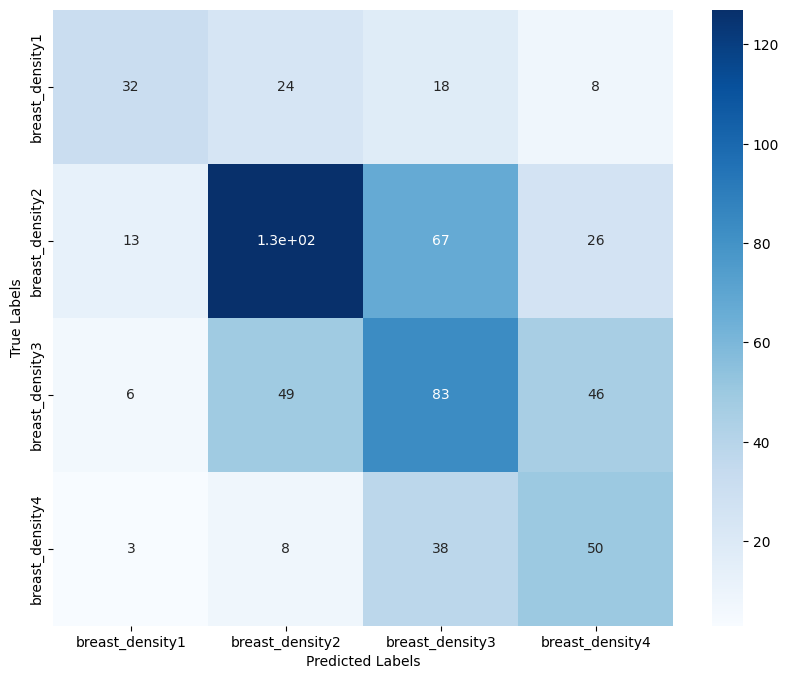

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 防止overfit

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import tqdm

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 超參數設置
num_epochs = 50
batch_size = 16
learning_rate = 0.001

# 設置訓練數據讀取器
train_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_dataset = ImageFolder("/home/kevinluo/breast_density_classification/datasets/train", transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 設置驗證數據讀取器
valid_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
valid_dataset = ImageFolder("/home/kevinluo/breast_density_classification/datasets/valid", transform=valid_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 設置測試數據讀取器
test_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_dataset = ImageFolder("/home/kevinluo/breast_density_classification/datasets/test", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 設置模型
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 160 * 160, 256)
        self.fc2 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 160 * 160)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x


# Move model and data to GPU
model = CNNClassifier().to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)


cuda:0


In [6]:
#設置損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 160 * 160, 256)
        self.fc2 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 160 * 160)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
#訓練模型
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
            # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 驗證模型
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Epoch [{}/{}], Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, 100 * correct / total))
    # 測試模型
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy: {:.2f}%'.format(100 * correct / total))



Epoch [1/50], Validation Accuracy: 55.52%
Test Accuracy: 52.01%
Epoch [2/50], Validation Accuracy: 48.83%
Test Accuracy: 51.84%
Epoch [3/50], Validation Accuracy: 49.83%
Test Accuracy: 51.34%
Epoch [4/50], Validation Accuracy: 48.83%
Test Accuracy: 52.68%
Epoch [5/50], Validation Accuracy: 45.82%
Test Accuracy: 46.66%
Epoch [6/50], Validation Accuracy: 45.82%
Test Accuracy: 49.16%
Epoch [7/50], Validation Accuracy: 45.82%
Test Accuracy: 47.66%
Epoch [8/50], Validation Accuracy: 45.82%
Test Accuracy: 51.00%
Epoch [9/50], Validation Accuracy: 45.82%
Test Accuracy: 51.00%
Epoch [10/50], Validation Accuracy: 46.49%
Test Accuracy: 50.00%
Epoch [11/50], Validation Accuracy: 48.16%
Test Accuracy: 51.00%
Epoch [12/50], Validation Accuracy: 42.81%
Test Accuracy: 48.16%
Epoch [13/50], Validation Accuracy: 46.15%
Test Accuracy: 48.49%
Epoch [14/50], Validation Accuracy: 45.15%
Test Accuracy: 48.49%
Epoch [15/50], Validation Accuracy: 48.16%
Test Accuracy: 51.51%
Epoch [16/50], Validation Accuracy

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x500 with 0 Axes>

## More complexity CNN

In [ ]:
from click import progressbar
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# 定義CNN模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 157 * 157, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 157 * 157)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 定義transforms，對數據進行預處理
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 載入訓練數據
train_dataset = datasets.ImageFolder(root='./train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# 載入驗證數據
valid_dataset = datasets.ImageFolder(root='./valid', transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=4)

# 載入測試數據
test_dataset = datasets.ImageFolder(root='./test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

# 初始化模型
model = Net()

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 訓練模型
num_epochs = 10
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

start_time = time.time()

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    # 訓練模型
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()
        
        progressbar(i, len(train_loader), 'Train Epoch {}: Loss: {:.6f}, Acc: {:.6f}'.format(epoch+1, train_loss/(i+1), train_acc/((i+1)*batch_size)))

    train_loss /= len(train_loader)
    train_acc /= len(train_set)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 驗證模型
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_acc += (predicted == labels).sum().item()
            
            progress_bar(i, len(valid_loader), 'Valid Epoch {}: Loss: {:.6f}, Acc: {:.6f}'.format(epoch+1, valid_loss/(i+1), valid_acc/((i+1)*batch_size)))
        
        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_set)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    # 記錄並輸出epoch的訓練結果
    print('Epoch {}: Train Loss: {:.6f}, Train Acc: {:.6f}, Valid Loss: {:.6f}, Valid Acc: {:.6f}'.format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))

